In [50]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, roc_auc_score

In [2]:
def read_file(x):
    #read in the csv file with low memory
    y = pd.read_csv(x, low_memory=False)
    return y

In [8]:
def process_data(df):
    df['patientunitstayid'] = df['patientunitstayid'].astype(int)
    df = df[df['nursingchartvalue'] != 'Unable to score due to medication']
    df['nursingchartvalue'] = pd.to_numeric(df['nursingchartvalue'], errors='coerce').astype(float)
    # copy all complete numbers and non-nan values at the beginnning of the dataset
    d = df[['admissionheight', 'admissionweight', 'age', 'gender', 'patientunitstayid', 'unitvisitnumber']].copy()
    #encode genders to get unique instances
    one_hot = pd.get_dummies(d['gender'])
    #use one hot encoding to generate dummies and catagorize the dataset
    d = pd.concat([d, one_hot], axis=1)
    #drop gender column
    d.drop('gender', axis=1, inplace=True)
    # replace the nonfloats/itns with ints 
    d.replace({'> 89': 100}, inplace = True)
    d = d.drop_duplicates(subset=['patientunitstayid'], keep='first')
    d = d.set_index('patientunitstayid')
    d['cellattributevalue'] = 0
    
    #copy another instence on the next part of the dataset
    d2 = df[['cellattributevalue', 'celllabel', 'offset', 'patientunitstayid']].copy()
    d2.dropna(inplace=True)
    #replace all nonfloat values with integers based off of numerics
    d2.replace({'< 2 seconds': 0}, inplace = True)
    d2.replace({'> 2 seconds': 1}, inplace = True)
    d2.replace({'normal': 2}, inplace = True)
    d2.replace({'hands': 3}, inplace = True)
    d2.replace({'feet': 4}, inplace = True)
    #index the patient ids with the cell atttributes to generate values in the finalized dataset
    for idx, row in d2.iterrows():
        id = row['patientunitstayid']
        if id in d.index and pd.isna(d.at[id, 'cellattributevalue']):
            d.at[id, 'cellattributevalue'] = row['cellattributevalue']
    #generate new columns         
    columns = ['pH', 'glucose']
    for column in columns: 
        d[column] = None
    
    d3 = df[['labname','labresult','offset','patientunitstayid']].copy()
    d3.dropna(inplace=True)
    #index the patient ids with the cell atttributes to generate values in the finalized dataset
    for i, row in d3.iterrows():
        id = row['patientunitstayid']
        labname = row['labname']
        labresult = row['labresult']
        if id in d.index:
            if pd.isna(d.loc[id, labname]):
                d.loc[id, labname] = labresult
            else:
                d.loc[id, labname] = min(d.loc[id, labname], labresult)
                
    #generate new columns             
    columns = ['GCS Total', 'Heart Rate', 'Non-Invasive BP Diastolic', 'Non-Invasive BP Mean', 'Non-Invasive BP Systolic', 'Invasive BP Diastolic', 'Invasive BP Mean', 'Invasive BP Systolic', 'Respiratory Rate', 'O2 Saturation']
    for column in columns: 
        d[column] = None
    #copy another instence on the last part of the dataset
    d4 = df[['nursingchartcelltypevalname','nursingchartvalue','offset','patientunitstayid']].copy()
    
    d4.dropna(inplace=True)
    #index the patient ids with the cell atttributes to generate values in the finalized dataset
    for i, row in d4.iterrows():
        id = row['patientunitstayid']
        if id in d.index:
            current_value = d.loc[id, row['nursingchartcelltypevalname']]
            new_value = row['nursingchartvalue']
            if current_value is None or current_value > new_value:
                d.loc[id, row['nursingchartcelltypevalname']] = new_value
    #convert all types to floats     
    d = d.astype(float)
    #get all nans to be imputed with the mean datasets for the rows
    d = d.fillna(d.mean())
    finalized = d
    return finalized

In [9]:
#establish file paths
x_train_file_path = 'train_x.csv'
x_test_file_path = 'test_x.csv'
y_train_file_path = 'train_y.csv'     

In [10]:
#read in the respective file paths to data frames
train_y = read_file(y_train_file_path)
train_x = read_file(x_train_file_path)
test_x = read_file(x_test_file_path)    

In [11]:
#check the dataset to make sure it remains a dataframe
type(train_x) 

pandas.core.frame.DataFrame

In [12]:
#process the data accordingly 
train_x = process_data(train_x)
test_x = process_data(test_x)      

<ipython-input-8-e9bd32941812>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['nursingchartvalue'] = pd.to_numeric(df['nursingchartvalue'], errors='coerce').astype(float)


In [13]:
#show the dataset to make sure it all matches the correct format
train_x

,admissionheight,admissionweight,age,unitvisitnumber,Female,Male,cellattributevalue,pH,glucose,GCS Total,Heart Rate,Non-Invasive BP Diastolic,Non-Invasive BP Mean,Non-Invasive BP Systolic,Invasive BP Diastolic,Invasive BP Mean,Invasive BP Systolic,Respiratory Rate,O2 Saturation
patientunitstayid,,,,,,,,,,,,,,,,,,,
141764,157.5,82.688572,87.0,2.0,1.0,0.0,0.0,7.301414,109.246531,12.549434,98.0,78.0,103.000000,153.0,45.550162,61.965035,93.23301,12.198135,88.000657
141765,157.5,46.500000,87.0,1.0,1.0,0.0,0.0,7.301414,61.000000,15.000000,74.0,59.0,75.000000,120.0,45.550162,61.965035,93.23301,14.000000,96.000000
143870,167.0,77.500000,76.0,1.0,0.0,1.0,0.0,7.390000,123.000000,15.000000,40.0,34.0,63.091616,93.0,30.000000,61.965035,100.00000,12.000000,94.000000
144815,172.7,60.300000,34.0,1.0,1.0,0.0,0.0,7.400000,82.000000,12.000000,68.0,46.0,61.000000,82.0,45.550162,61.965035,93.23301,7.000000,94.000000
145427,177.8,91.700000,61.0,1.0,0.0,1.0,0.0,7.301414,118.000000,15.000000,49.0,47.0,63.091616,79.0,45.550162,61.965035,93.23301,9.000000,90.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3351297,159.0,77.300000,52.0,1.0,0.0,1.0,0.0,7.413000,96.000000,12.549434,42.0,58.0,78.000000,109.0,45.550162,61.965035,93.23301,12.000000,78.000000
3351763,165.1,134.500000,62.0,1.0,1.0,0.0,0.0,7.375000,87.000000,8.000000,91.0,42.0,61.000000,92.0,40.000000,55.000000,85.00000,18.000000,91.000000
3352231,177.8,127.000000,41.0,1.0,0.0,1.0,0.0,7.393000,85.000000,12.549434,51.0,60.0,77.000000,105.0,45.550162,61.965035,93.23301,13.000000,93.000000


In [14]:
# Define the GradientBoostingRegressor with the specified hyperparameters
gb = GradientBoostingRegressor(n_estimators=600,
                                learning_rate=0.01,
                                max_depth=2,
                                min_samples_leaf=4,
                                min_samples_split=2,
                                subsample=0.5,
                                random_state=42)

# Fit the GradientBoostingRegressor to the training data
gb.fit(train_x, train_y['hospitaldischargestatus'])

# Use the trained model to predict the target variable for the test data
y_pred = gb.predict(test_x)

# Create a new DataFrame containing the patientunitstayid column from the test data
done = test_x.filter(['patientunitstayid'])

# Add the predicted hospitaldischargestatus values to the done DataFrame
done['hospitaldischargestatus'] = y_pred

# Save the done DataFrame to a CSV file
done.to_csv('result.csv')

In [15]:
# print the done dataframe for results
done

,hospitaldischargestatus
patientunitstayid,
151179,0.286425
151900,0.027540
152954,0.047127
158056,-0.008291
159411,-0.025504
...,...
3343295,-0.001670
3344944,0.043451
3347502,0.032613


In [51]:
# array of arrays with it being p[['Name', 'Acc', 'MSE', 'R2']] if none then 0
total_Scores = []

Below is code imported from chatgpt to optimize hyperparams for GradientBoostingRegressor as this is the only ML model this project is using for simplicity purposes. 

In [52]:
from sklearn.linear_model import LinearRegression
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y['hospitaldischargestatus'], test_size=0.2, random_state=42)

# Create a linear regression object and fit the training data
model = LinearRegression()
model.fit(X_train, y_train)

# Predict values for the testing data
y_pred = model.predict(X_test)

# Calculate the accuracy of the model
accuracy = model.score(X_test, y_test)

# Print the accuracy score
print("Accuracy:", accuracy)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
auroc = roc_auc_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)
print("AUROC:", auroc)
array = ['Lin',accuracy, mse, r2, auroc]
total_Scores.append(array)

Accuracy: 0.15455942893920294
Mean Squared Error: 0.07541916671554999
R^2 Score: 0.15455942893920294
AUROC: 0.8379120879120878


In [53]:
X = train_x
y = train_y['hospitaldischargestatus']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = GradientBoostingRegressor(n_estimators=600,
                                learning_rate=0.01,
                                max_depth=2,
                                min_samples_leaf=4,
                                min_samples_split=2,
                                subsample=0.5,
                                random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

acc = accuracy_score(train_y['hospitaldischargestatus'], gb.predict(train_x).round())
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
auroc = roc_auc_score(y_test, y_pred)

print("Accuracy:", acc)
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)
print("AUROC:", auroc)
array = ['GBR',acc , mse, r2, auroc]
total_Scores.append(array)

Accuracy: 0.9434523809523809
Mean Squared Error: 0.06766699526693154
R^2 Score: 0.2414604189912435
AUROC: 0.8483516483516483


In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X = train_x
y = train_y['hospitaldischargestatus']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
auroc = roc_auc_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)
print("AUROC:", auroc)

array = ['RFC',accuracy, mse, r2, auroc]
total_Scores.append(array)

Accuracy: 0.9084158415841584
Mean Squared Error: 0.09158415841584158
R^2 Score: -0.02664835164835133
AUROC: 0.5375


In [55]:
from sklearn.linear_model import LogisticRegression

X = train_x
y = train_y['hospitaldischargestatus']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
auroc = roc_auc_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)
print("AUROC:", auroc)

array = ['Log',accuracy, mse, r2, auroc]
total_Scores.append(array)

Accuracy: 0.9158415841584159
Mean Squared Error: 0.08415841584158416
R^2 Score: 0.056593406593406836
AUROC: 0.6083791208791209


C:\Users\Caleb\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [56]:
from sklearn.svm import SVC

X = train_x
y = train_y['hospitaldischargestatus']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = SVC(kernel='linear', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
auroc = roc_auc_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)
print("AUROC:", auroc)

array = ['SVM',accuracy, mse, r2, auroc]
total_Scores.append(array)

Accuracy: 0.900990099009901
Mean Squared Error: 0.09900990099009901
R^2 Score: -0.1098901098901095
AUROC: 0.5


In [57]:
from sklearn.neighbors import KNeighborsClassifier

X = train_x
y = train_y['hospitaldischargestatus']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
auroc = roc_auc_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)
print("AUROC:", auroc)

array = ['KNN',accuracy, mse, r2, auroc]
total_Scores.append(array)

Accuracy: 0.9084158415841584
Mean Squared Error: 0.09158415841584158
R^2 Score: -0.02664835164835133
AUROC: 0.5597527472527473


In [58]:
print(total_Scores)

[['Lin', 0.15455942893920294, 0.07541916671554999, 0.15455942893920294, 0.8379120879120878], ['GBR', 0.9434523809523809, 0.06766699526693154, 0.2414604189912435, 0.8483516483516483], ['RFC', 0.9084158415841584, 0.09158415841584158, -0.02664835164835133, 0.5375], ['Log', 0.9158415841584159, 0.08415841584158416, 0.056593406593406836, 0.6083791208791209], ['SVM', 0.900990099009901, 0.09900990099009901, -0.1098901098901095, 0.5], ['KNN', 0.9084158415841584, 0.09158415841584158, -0.02664835164835133, 0.5597527472527473]]


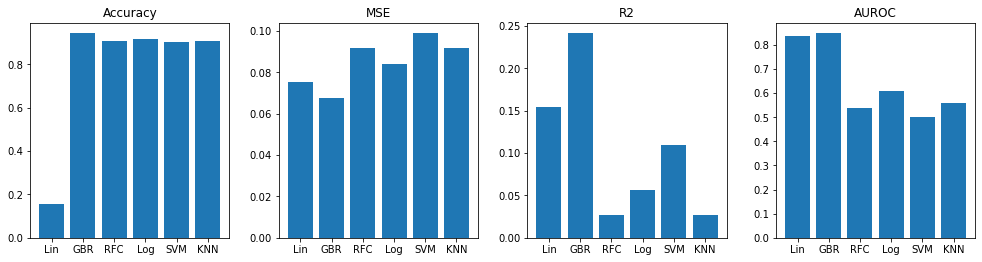

In [63]:
import numpy as np
import matplotlib.pyplot as plt

# Define the data to be plotted
data = total_Scores

# Extract the model names and accuracy, MSE, and R2 values from the data
models = [d[0] for d in data]
accuracy = [d[1] for d in data]
mse = [d[2] for d in data]
r2 = [abs(d[3]) for d in data]
auroc = [d[4] for d in data]

# Set up the subplots for the bar graphs
fig, axs = plt.subplots(1, 4, figsize=(14, 4))

# Plot the accuracy values
axs[0].bar(models, accuracy)
axs[0].set_title('Accuracy')

# Plot the MSE values
axs[1].bar(models, mse)
axs[1].set_title('MSE')

# Plot the R2 values
axs[2].bar(models, r2)
axs[2].set_title('R2')

# Plot the AUROC values
axs[3].bar(models, auroc)
axs[3].set_title('AUROC')

# Add some space between the subplots and adjust their layout
fig.tight_layout(pad=2)

# Display the graph
plt.show()